## Model evaluation

In [ ]:
using Flux
using Flux: DataLoader
using Plots
using DataFrames
using Printf
using BSON, JSON
using Arrow
using StatsBase
using Statistics
using Unicode
using Random

In [ ]:
using Revise
using TokenizersLite
using TransformersLite

In [ ]:
include("reporting.jl")
include("utilities.jl")
include("training.jl")
include("SentenceClassifier.jl")

v_weighted_average (generic function with 1 method)

## Load data

raw

In [ ]:
path = "datasets\\amazon_reviews_multi\\en\\1.0.0\\"
file_train = "amazon_reviews_multi-train.arrow"
file_test = "amazon_reviews_multi-test.arrow" ;

In [ ]:
fingerprint = readdir(path)[1]
filepath = joinpath(path, fingerprint, file_train)
df = DataFrame(Arrow.Table(filepath))

checksum = readdir(path)[1]
filepath = joinpath(path, checksum, file_test)
df_test = DataFrame(Arrow.Table(filepath));

In [ ]:
nrow(df)

200000

filtered

In [ ]:
documents = df[:, "review_body"]
labels = df[:, "stars"]

println("training samples: ", size(documents), " ", size(labels))

training samples: (200000,) (200000,)


test

In [ ]:
documents_test = df_test[:, "review_body"]
labels_test = df_test[:, "stars"];

println("test samples: ", size(documents_test), " ", size(labels_test))

test samples: (5000,) (5000,)


models

In [ ]:
directory = "../outputs/20230701_1325_n1_sen"
saved_objects = BSON.load(joinpath(directory, "model.bson"))

Dict{Symbol, Any} with 4 entries:
  :tokenizer         => BytePairEncoder{String}(length(rules)=8000, length(cach…
  :indexer           => IndexTokenizer{String}(length(vocabulary)=7455, unksym=…
  :sentence_splitter => RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z…
  :model             => SentenceClassifer(base_model=TransformerClassifier{Embe…

In [ ]:
tokenizer = saved_objects[:tokenizer]
@show tokenizer
indexer = saved_objects[:indexer]
@show indexer
sentence_splitter = saved_objects[:sentence_splitter ]
@show sentence_splitter 
model = saved_objects[:model]
display(model)
display(model.base_model)
display(model.aggregate)

tokenizer = BytePairEncoder{String}(length(rules)=8000, length(cache)=0, unksym=[UNK], startsym=⋅, symbols=["##a", "##b", "##c", "##d", "##e", "##f", "##g", "##h", "##i", "##j", "##k", "##l", "##m", "##n", "##o", "##p", "##q", "##r", "##s", "##t", "##u", "##v", "##w", "##x", "##y", "##z", "⋅a", "⋅b", "⋅c", "⋅d", "⋅e", "⋅f", "⋅g", "⋅h", "⋅i", "⋅j", "⋅k", "⋅l", "⋅m", "⋅n", "⋅o", "⋅p", "⋅q", "⋅r", "⋅s", "⋅t", "⋅u", "⋅v", "⋅w", "⋅x", "⋅y", "⋅z", ",", ".", "?", "!", ":", ";", "\$", "€", "£", "&"])
indexer = IndexTokenizer{String}(length(vocabulary)=7455, unksym=[UNK])
sentence_splitter = RuleBasedSentenceSplitter(non_breaking_prefixes=Set(["Z", "C", "P", "Jul", "Eg", "Dec", "Sen", "Rev", "Mar", "BComm", "co", "Mon", "Sep", "Y", "U", "Jan", "Fig", "Prof", "al", "K", "BA", "V", "BSc", "Ph.d", "Phd", "H", "Feb", "Rep", "Mr", "S", "MA", "Jr", "PhD", "F", "W", "T", "Aug", "Dept", "L", "O", "B", "fig", "M", "Capt", "Sun", "Gen", "prof", "X", "Corp", "Gov", "Tues", "corp", "Ie", "D", "BCom", "BEng

SentenceClassifer(base_model=TransformersLite.TransformerClassifier{Embed{Matrix{Float32}}, PositionEncoding{Matrix{Float32}}, Dropout{Float64, Colon, TaskLocalRNG}, Vector{TransformerEncoderBlock}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, FlattenLayer, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}}(Embed((32, 7455)), PositionEncoding(32), Dropout(0.1), TransformerEncoderBlock[TransformerEncoderBlock(MultiheadAttention(num_heads=4, head_size=8, 32=>32), LayerNorm(32), Dense(32 => 128, relu), Dense(128 => 32), LayerNorm(32))], Dense(32 => 1), FlattenLayer(), Dense(30 => 1)), activation=σ, aggregate=parabolic_weighted_average)

TransformerClassifier(
  Embed((32, 7455)),                    # 238_560 parameters
  PositionEncoding(32),
  Dropout(0.1),
  TransformerEncoderBlock(
    MultiheadAttention(num_heads=4, head_size=8, 32=>32)(
      denseQ = Dense(32 => 32),         # 1_056 parameters
      denseK = Dense(32 => 32),         # 1_056 parameters
      denseV = Dense(32 => 32),         # 1_056 parameters
      denseO = Dense(32 => 32),         # 1_056 parameters
    ),
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
    Dense(32 => 128, relu),             # 4_224 parameters
    Dense(128 => 32),                   # 4_128 parameters
    Dropout(0.1),
    LayerNorm(32),                      # 64 parameters
  ),
  Dense(32 => 1),                       # 33 parameters
  FlattenLayer(),
  Dense(30 => 1),                       # 31 parameters
)        # Total: 21 trainable arrays, 251_328 parameters,
          # plus 1 non-trainable, 32_000 parameters, summarysize 1.082 MiB.

parabolic_weighted_average (generic function with 1 method)

In [ ]:
max_length = size(model.base_model.classifier.weight, 2)

30

## Tokenizers

In [ ]:
function pad!(v::Vector{String}, sym::String, max_length::Int)
    if length(v) < max_length
        padding = [sym for i in 1:(max_length - length(v))]
        append!(v, padding)
    end
end

pad! (generic function with 1 method)

In [ ]:
@time documents_split = [sentence_splitter(d) for d in documents];
@time documents_test_split = [sentence_splitter(d) for d in documents_test];

  8.059443 seconds (57.14 M allocations: 3.780 GiB, 8.46% gc time, 1.58% compilation time)
  0.258520 seconds (1.46 M allocations: 97.056 MiB, 17.52% gc time, 17.80% compilation time)


In [ ]:
tokens = Vector{Vector{String}}[]
@time for sentences in documents_split
    tokens_doc = map(s->preprocess(s, tokenizer, max_length=max_length), sentences)
    pad!(tokens_doc[1], tokenizer.unksym, max_length) # hack to ensure all indices have common length
    push!(tokens, tokens_doc)
end
@time indices = map(t->indexer(t), tokens) 

y_train = copy(labels)
y_train[labels .≤ 2] .= 0
y_train[labels .≥ 4] .= 1
idxs = labels .!= 3

X_train, y_train = indices[idxs], y_train[idxs];
train_data, val_data = split_validation(X_train, y_train; rng=MersenneTwister(2718))

println("train samples:      ", size(train_data[1]), " ", size(train_data[2]))
println("validation samples: ", size(val_data[1]), " ", size(val_data[2]))

 50.906332 seconds (662.18 M allocations: 17.511 GiB, 10.54% gc time, 1.12% compilation time)
 23.707713 seconds (648.05 k allocations: 180.545 MiB, 0.67% compilation time)
train samples:      (144000,) (144000,)
validation samples: (16000,) (16000,)


In [ ]:
y_test = copy(labels_test)
y_test[labels_test .≤ 2] .= 0
y_test[labels_test .≥ 4] .= 1
idxs = labels_test .!= 3

tokens = Vector{Vector{String}}[]
@time for sentences in documents_test_split
    tokens_doc = map(s->preprocess(s, tokenizer, max_length=max_length), sentences)
    pad!(tokens_doc[1], tokenizer.unksym, max_length) # hack to ensure all indices have common length
    push!(tokens, tokens_doc)
end
@time indices_test = map(t->indexer(t), tokens) 

X_test, y_test = indices_test[idxs], y_test[idxs]
documents_test_sub = documents_test[idxs]

println("test indices: ", size(indices_test))
println("test samples: ", size(X_test), " ", size(y_test))

  0.757411 seconds (6.17 M allocations: 187.921 MiB, 28.92% gc time, 7.36% compilation time)
  0.641566 seconds (61.22 k allocations: 6.839 MiB, 8.73% compilation time)
test indices: (5000,)
test samples: (4000,) (4000,)


In [ ]:
train_data_loader = DataLoader(train_data; batchsize=32, shuffle=false);
val_data_loader  = DataLoader(val_data; batchsize=32, shuffle=false);

## Evaluate

In [ ]:
loss(x, y) = Flux.binarycrossentropy(model(x), y);
loss(x::Tuple) = loss(x[1], x[2]);
accuracy(ŷ, y) = mean((ŷ .> 0.5) .== y);

In [ ]:
@time batched_metric(accuracy, train_data_loader, g=model)

103.625762 seconds (59.48 M allocations: 68.677 GiB, 10.29% gc time, 11.65% compilation time)


0.9177083333333333

In [ ]:
@time batched_metric(accuracy, val_data_loader, g=model)

  9.823766 seconds (2.45 M allocations: 7.465 GiB, 10.75% gc time)


0.89025

In [ ]:
history = open(joinpath(directory, "history.json"), "r") do f
    history=JSON.parse(read(f, String))
end

Dict{String, Any} with 4 entries:
  "train_loss" => Any[0.333835, 0.303591, 0.281763, 0.261838, 0.252773, 0.24676…
  "train_acc"  => Any[0.861708, 0.882097, 0.8915, 0.90134, 0.905715, 0.908375, …
  "val_acc"    => Any[0.852688, 0.872812, 0.881687, 0.887188, 0.889563, 0.892, …
  "val_loss"   => Any[0.344941, 0.316424, 0.302708, 0.287998, 0.283943, 0.28109…

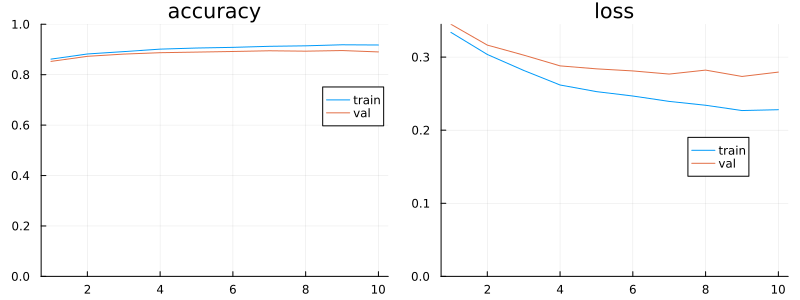

In [ ]:
epochs = 1:length(history["train_acc"])
p1 = plot(epochs, history["train_acc"], label="train")
plot!(p1, epochs, history["val_acc"], label="val")
plot!(p1, ylims=[0, 1], title="accuracy", legend=(0.9, 0.7))

p2 = plot(epochs, history["train_loss"], label="train")
plot!(p2, epochs, history["val_loss"], label="val")
plot!(p2, title="loss", ylims=[0, Inf], legend=(0.8, 0.5))

p = plot(p1, p2, layout=grid(1, 2), size=(800, 300))
savefig(p, joinpath(directory, "history.png"))
p

## Test data

In [ ]:
probs = model(X_test)
accuracy(probs, y_test)

0.884

In [ ]:
y_pred = Int.(probs .> 0.5);

In [ ]:
cm = confusion_matrix(vec(y_pred), vec(y_test), 0:1)

2×2 Matrix{Int64}:
 1748   252
  212  1788

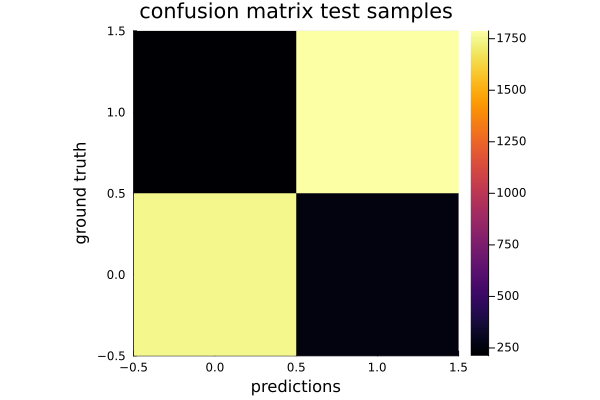

In [ ]:
p = heatmap(0:1, 0:1, cm, xlabel="predictions", ylabel="ground truth", xlims=(-0.5,1.5), aspectratio=1, 
    title="confusion matrix test samples")
savefig(p, joinpath(directory, "confusion_matrix_classification.png"))
p

In [ ]:
classification_report(cm, 0:1)

              precision  recall  f1-score  support
           0       0.89    0.87      0.88     2000
           1       0.88    0.89      0.89     2000

weighted avg       0.88    0.88      0.88     4000

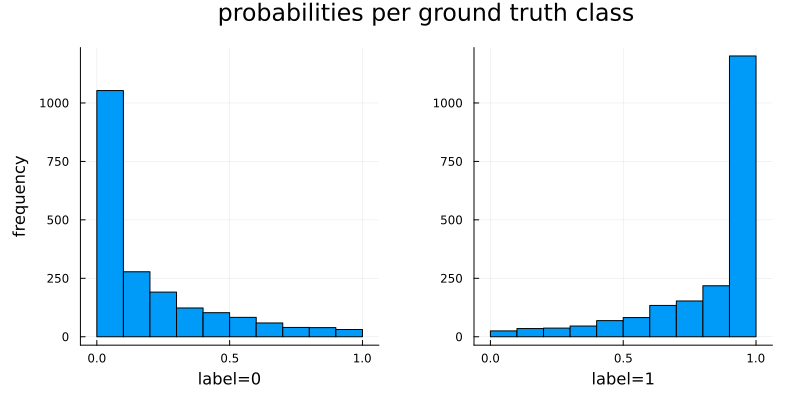

In [ ]:
p = plot()
canvases = []
for label in 0:1
    idxs = y_test .== label
    c = histogram(probs[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="label=$label", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 2), link=:y, size=(800, 400), plot_title="probabilities per ground truth class",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_ground_truth.png"))
p

### Examples

In [ ]:
pos_max = argmax(probs)
pos_min = argmin(probs)


println(" idx  y  ŷ    prob  ")
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_max, y_test[pos_max], y_pred[pos_max], probs[pos_max], documents_test_sub[pos_max]
)
@printf("%4d  %d  %d  %.4f  %s\n",
    pos_min, y_test[pos_min], y_pred[pos_min], probs[pos_min], documents_test_sub[pos_min]
)

 idx  y  ŷ    prob  
2402  1  1  1.0000  They were exactly what I needed at the very affordable price and in many colors
 269  0  0  0.0000  Unfortunately never received product


In [ ]:
nshow = 3

for label in [0, 1]
    idxs = y_test .== label
    idxs_label = (1:size(y_test, 1))[vec(idxs)]
    idxs_correct = idxs_label[y_pred[idxs] .== label]
    idxs_wrong = idxs_label[y_pred[idxs] .!== label]
    @printf("correct: %d / %d\n", length(idxs_correct), length(idxs_label))
    println(" idx  y  ŷ    prob  ")
    for idxs_subset in [idxs_correct, idxs_wrong]
        for idx in sample(idxs_subset, nshow, replace=false)
            @printf("%4d  %d  %d  %.4f\n",
                idx, y_test[idx], y_pred[idx], probs[idx], 
            )
            sentences = documents_test_split[labels_test.!==3][idx]
            y = predict_probs(model, X_test[idx])
            for (p, s) in zip(y, sentences)
                @printf("\t    %.4f %s\n", p, s)
            end
        end
    end
    println("")
end

correct: 1748 / 2000
 idx  y  ŷ    prob  
 670  0  0  0.0050
	    0.0050 Only lasted 2 months!
 650  0  0  0.0045
	    0.0045 Did not receive I want a refund
 319  0  0  0.0480
	    0.0480 I never got my order
 825  0  1  0.6010
	    0.6010 Very drying on my hair .
1816  0  1  0.9218
	    0.4060 I bought this for my son’s new bed but am sending it back immediately!
	    0.9449 It’s very soft and a little plush but has plastic in it so it’s So noisy!!
 895  0  1  0.8571
	    0.9632 I loved the first book so much had to read the sequel.
	    0.2982 Actually couldn't believe it was even better than the first

correct: 1788 / 2000
 idx  y  ŷ    prob  
2096  1  1  0.8788
	    0.8053 Fit was made incredibly snug by a short zipper.
	    0.9998 Should have expected a barrier with the value price.
3903  1  1  0.9937
	    0.9958 I enjoyed this book and plan to read it to our 2nd grade class.
2721  1  1  0.9413
	    0.9983 Leaves hair feeling and looking very oily.
	    0.7864 Smells great.
	    

## Influence of sentence count

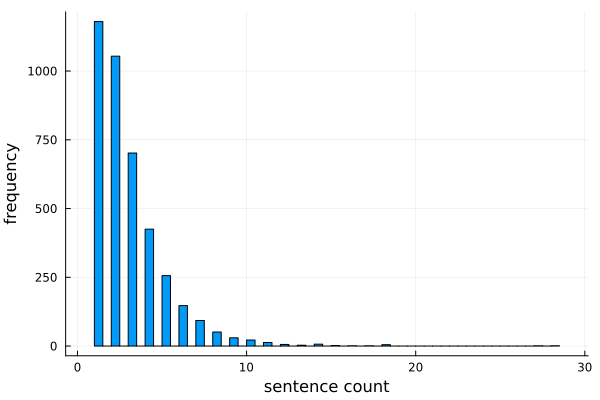

In [ ]:
sentence_counts = length.(documents_test_split[labels_test .!= 3])

p = histogram(sentence_counts, xlabel="sentence count", ylabel="frequency", label="")
savefig(p, joinpath(directory, "sentence_counts.png"))
p

In [ ]:
accuracies = Float64[]
for sentence_count in 1:maximum(sentence_counts)
    idxs = sentence_counts .== sentence_count;
    acc = count(idxs) > 0 ? accuracy(probs[idxs], y_test[idxs]) : NaN
    push!(accuracies, acc)
end

In [ ]:
cum_accuaracies = []
count_total = 0
acc = 0.0
for i in 1:maximum(sentence_counts)
    count_i = count(sentence_counts .== i)
    acc_i = isnan(accuracies[i]) ? 0 : accuracies[i]
    acc = (count_i * acc_i + count_total * acc)/(count_i + count_total)
    count_total += count_i
    push!(cum_accuaracies, acc)
end

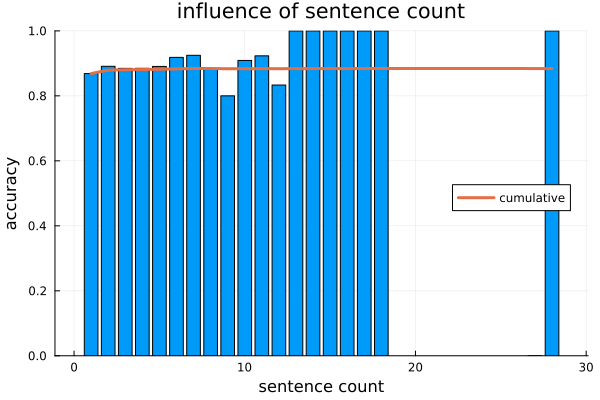

In [ ]:
bar(1:maximum(sentence_counts), accuracies, label="",
    xlabel="sentence count",
    ylabel="accuracy",
    title="influence of sentence count",
    ylims=(0, 1),
    )
p = plot!(1:maximum(sentence_counts), cum_accuaracies, linewidth=3, label="cumulative", legend_position=:right)
savefig(p, joinpath(directory, "accuracy_sentence_count.png"))
p

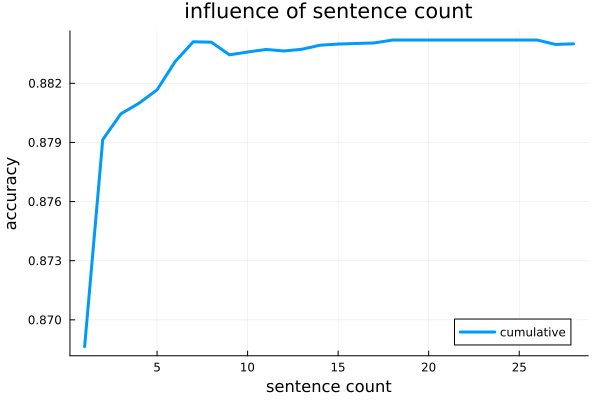

In [ ]:
p = plot(1:maximum(sentence_counts), cum_accuaracies, linewidth=3, label="cumulative",
    xlabel="sentence count",
    ylabel="accuracy",
    title="influence of sentence count",
    )
savefig(p, joinpath(directory, "accuracy_sentence_count_cummulative.png"))
p

### Test data including star=3

In [ ]:
probs_all = model(indices_test);
y_pred_all = Int.(probs_all .> 0.5);

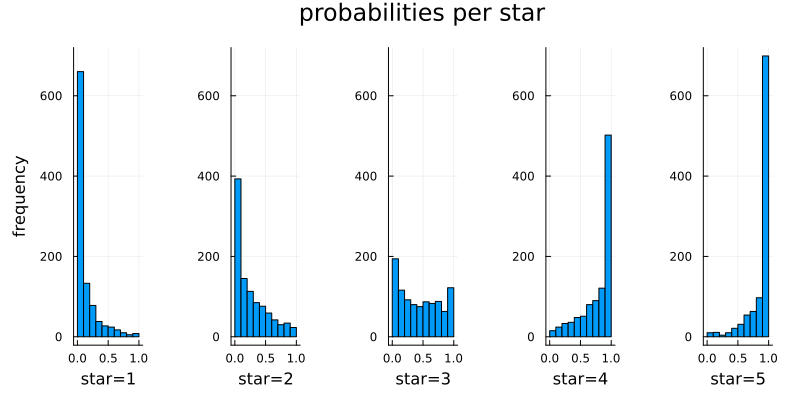

In [ ]:
p = plot()
canvases = []
for star in 1:5
    idxs = labels_test .== star
    c = histogram(probs_all[idxs], label="", xticks=([0.00, 0.50, 1.00]), xlabel="star=$star", nbins=12)
    push!(canvases, c)
end
plot!(canvases[1], ylabel="frequency")
p = plot(canvases..., layout=(1, 5), link=:y, size=(800, 400), plot_title="probabilities per star",
    margin=5Plots.mm)
savefig(p, joinpath(directory, "probabilities_star.png"))
p

In [ ]:
nshow = 3

star = 3
println("star = $star")
idxs = labels_test .== star
idxs_label = (1:length(labels_test))[vec(idxs)]
println(" idx  y  ŷ    prob  ")
for idx in sample(idxs_label, nshow, replace=false)
    @printf("%4d  %d  %d  %.4f\n",
            idx, y_test[idx], y_pred[idx], probs[idx], 
        )
    sentences = documents_test_split[idx]
    y = predict_probs(model, X_test[idx])
    for (p, s) in zip(y, sentences)
        @printf("\t    %.4f %s\n", p, s)
    end
end

star = 3
 idx  y  ŷ    prob  
2071  1  1  0.9879
	    0.4278 It's an ok bin.
	    0.9996 I got it to use as a clothes hamper thinking it was more of a linen material, probably my mistake for not reading the description better but it's actually more like a plastic.
2639  1  1  0.9556
	    0.9952 Kept it, but I would not buy another one of these ~ feels unpleasant in the hand.
	    0.6945 It's okay as a one-off, but not a utensil that you'd wish to use over-and-over-again in sequence.
	    0.6506 You'd want one with a more comfortable handle.
2919  1  0  0.2459
	    0.3661 Too large.
	    0.3204 Thank you for the return


## Single samples

In [ ]:
idx = 4700  

text = documents_test[idx]

println(labels_test[idx])
println(text)
println("")

sentences = sentence_splitter(text)
tokens = [preprocess(s, tokenizer, max_length=max_length) for s in sentences]
for t in tokens
    println(join(t, "|"))
end
pad!(tokens[1], tokenizer.unksym, max_length)
x = indexer(tokens);

5
This makes almost the whole series. Roman Nights will be the last one. Loved them all. Alaskan Nights was awesome. Met my expectations , hot SEAL hero, beautiful & feisty woman. Filled with intrigue, steamy romance & nail biting ending. Have read two other books of yours. Am looking forward to more.

⋅this|⋅makes|⋅almost|⋅the|⋅whole|⋅series
⋅rom|##an|⋅nights|⋅will|⋅be|⋅the|⋅last|⋅one
⋅loved|⋅them|⋅all
⋅al|##ask|##an|⋅nights|⋅was|⋅awesome
⋅met|⋅my|⋅expectations|⋅hot|⋅seal|⋅hero|⋅beautiful|⋅fe|##ist|##y|⋅woman
⋅filled|⋅with|⋅intrig|##ue|⋅stea|##my|⋅romance|⋅nail|⋅bit|##ing|⋅ending
⋅have|⋅read|⋅two|⋅other|⋅books|⋅of|⋅your|##s
⋅am|⋅looking|⋅forward|⋅to|⋅more


In [ ]:
y = predict_probs(model, x)
@printf "mean: %.4f ; weighted mean: %.4f\n" mean(y) parabolic_weighted_average(y)
for (prob, sentence) in zip(y, sentences)
    @printf("%.4f %s\n", prob, sentence)
end

mean: 0.8461 ; weighted mean: 0.9563
0.8458 This makes almost the whole series.
0.5289 Roman Nights will be the last one.
0.9998 Loved them all.
0.9893 Alaskan Nights was awesome.
0.9907 Met my expectations , hot SEAL hero, beautiful & feisty woman.
0.9837 Filled with intrigue, steamy romance & nail biting ending.
0.6350 Have read two other books of yours.
0.7959 Am looking forward to more.
